# Storm Swaths Generation

## 0 Setup environment

In [1]:
import os

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
import seaborn as sns
from shapely.geometry import Point, Polygon, box

In [2]:
BASE_PATH = "./data"

BOUNDARIES_FILE = os.path.join(BASE_PATH, "boundaries.gpkg")
TRANSPORT_NETWORK_FILE = os.path.join(BASE_PATH, "merged_network_simplified.graphml")
STORM_TRACKS_FILE = os.path.join(BASE_PATH, "ibtracs.ALL.list.v04r01.csv")

## 1 Load storm tracks from IBTrACS

In [3]:
gdf_boundaries = gpd.read_file(BOUNDARIES_FILE)
gdf_boundaries.head()

,town,province,geometry
0,Bacacay,Albay,"MULTIPOLYGON (((123.84193 13.3341, 123.84204 1..."
1,Camalig,Albay,"MULTIPOLYGON (((123.6559 13.06131, 123.65536 1..."
2,Daraga,Albay,"MULTIPOLYGON (((123.71487 13.03995, 123.71474 ..."
3,Guinobatan,Albay,"MULTIPOLYGON (((123.68355 13.25321, 123.67729 ..."
4,Jovellar,Albay,"MULTIPOLYGON (((123.6559 13.06131, 123.65568 1..."


In [4]:
usecols = ["SID", "SEASON", "NATURE", "LAT", "LON", "TOKYO_R30_LONG"]
df_storms = pd.read_csv(STORM_TRACKS_FILE, usecols=usecols, na_values=[" "])

for col in ["SEASON", "LAT", "LON", "TOKYO_R30_LONG"]:
    df_storms[col] = pd.to_numeric(df_storms[col], errors="coerce")

df_storms = df_storms.dropna(subset=["SID", "SEASON", "LAT", "LON"])
print(f"Loaded {df_storms['SID'].nunique()} unique storms and {len(df_storms)} total records.")

/tmp/ipykernel_24298/2726862864.py:2: DtypeWarning: Columns (1,8,9,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_storms = pd.read_csv(STORM_TRACKS_FILE, usecols=usecols, na_values=[" "])


Loaded 13460 unique storms and 718675 total records.


In [5]:
geometry = [Point(xy) for xy in zip(df_storms["LON"], df_storms["LAT"])]
gdf_storms = gpd.GeoDataFrame(df_storms, geometry=geometry, crs=gdf_boundaries.crs)
gdf_storms.head()

,SID,SEASON,NATURE,LAT,LON,TOKYO_R30_LONG,geometry
1,1842298N11080,1842.0,NR,10.9,80.3,NaN,POINT (80.3 10.9)
2,1842298N11080,1842.0,NR,10.9,79.8,NaN,POINT (79.8 10.9)
3,1842298N11080,1842.0,NR,10.8,79.4,NaN,POINT (79.4 10.8)
4,1842298N11080,1842.0,NR,10.8,78.9,NaN,POINT (78.9 10.8)
5,1842298N11080,1842.0,NR,10.8,78.4,NaN,POINT (78.4 10.8)


## 2 Filter storms along PAR

In [6]:
par_coords = [(120, 25), (135, 25), (135, 5), (115, 5), (115, 15), (120, 21), (120, 25)]
gdf_par = gpd.GeoDataFrame([1], geometry=[Polygon(par_coords)], crs=gdf_boundaries.crs)

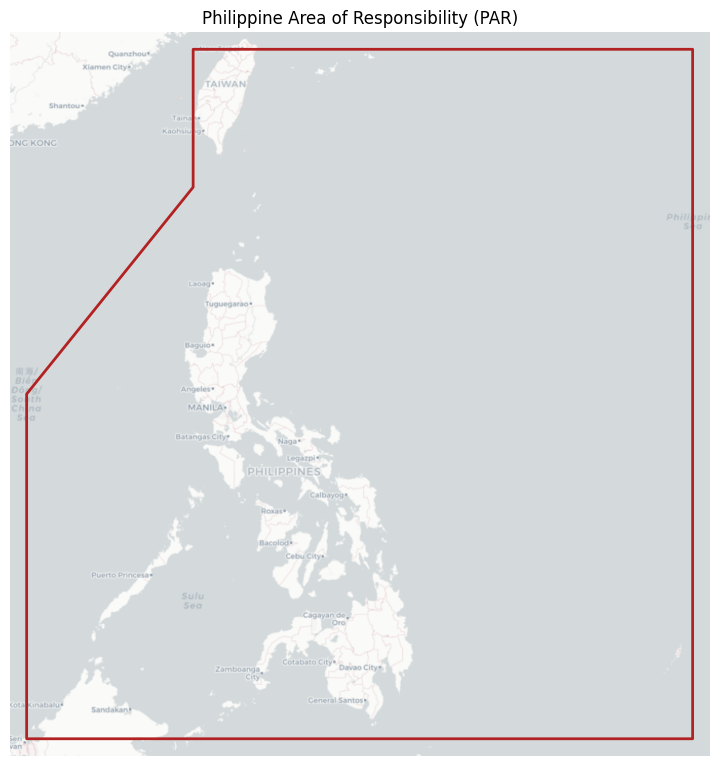

In [7]:
_, ax = plt.subplots(figsize=(8, 8))

gdf_par.plot(ax=ax, color="none", edgecolor="firebrick", linewidth=2)

x_min, y_min, x_max, y_max = gdf_par.total_bounds
padding = 0.5
ax.set_xlim(x_min - padding, x_max + padding)
ax.set_ylim(y_min - padding, y_max + padding)

cx.add_basemap(ax, crs=gdf_boundaries.crs, source=cx.providers.CartoDB.Positron, attribution="")

plt.title("Philippine Area of Responsibility (PAR)")
plt.tight_layout()
plt.axis("off")

filepath = os.path.join(BASE_PATH, "par_polygon.png")
plt.savefig(filepath, dpi=300, bbox_inches="tight")

plt.show()

In [8]:
sids_in_par = gpd.sjoin(gdf_storms, gdf_par, how="inner", predicate="within")["SID"].unique()
gdf_storms_par = gdf_storms[gdf_storms["SID"].isin(sids_in_par)]
gdf_storms_par = gdf_storms_par[gdf_storms_par["NATURE"] == "TS"]

print(f"Found {len(gdf_storms_par['SID'].unique())} tropical storms that passed through the PAR.")

Found 2662 tropical storms that passed through the PAR.


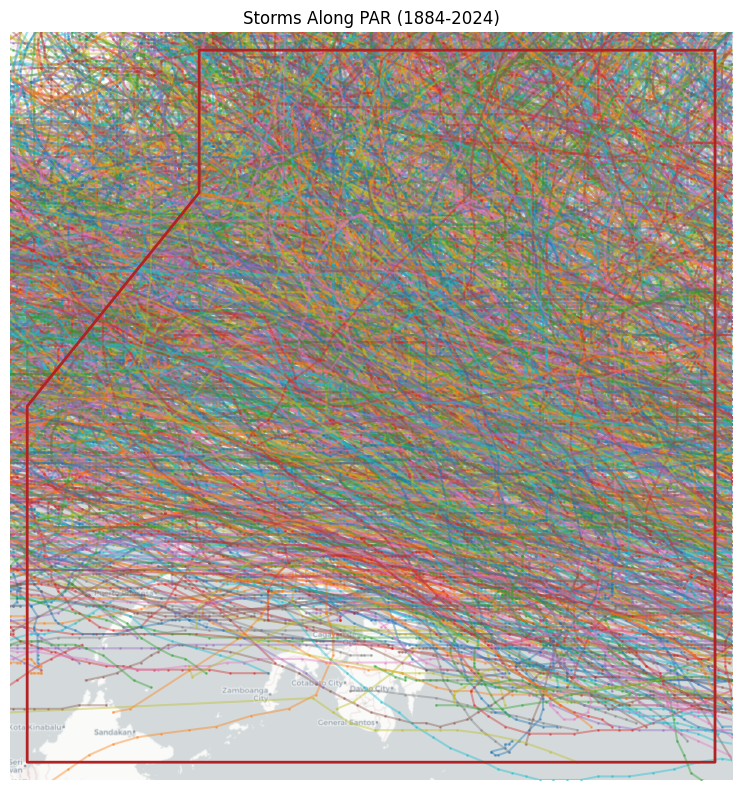

In [9]:
_, ax = plt.subplots(figsize=(8, 8))

gdf_par.plot(ax=ax, color="none", edgecolor="firebrick", linewidth=2, zorder=3)

x_min, y_min, x_max, y_max = gdf_par.total_bounds
padding = 0.5
ax.set_xlim(x_min - padding, x_max + padding)
ax.set_ylim(y_min - padding, y_max + padding)

cx.add_basemap(ax, crs=gdf_boundaries.crs, source=cx.providers.CartoDB.Positron, attribution="")

for storm_id in gdf_storms_par["SID"].unique():
    track = gdf_storms_par[gdf_storms_par["SID"] == storm_id]
    ax.plot(track.geometry.x, track.geometry.y, marker="o", linestyle="-", markersize=1, alpha=0.4)

min_year, max_year = int(gdf_storms_par["SEASON"].min()), int(gdf_storms_par["SEASON"].max())
plt.title(f"Storms Along PAR ({min_year}-{max_year})")
plt.axis("off")
plt.tight_layout()

filepath = os.path.join(BASE_PATH, "storm_tracks.png")
plt.savefig(filepath, dpi=300, bbox_inches="tight")

plt.show()

## 3 Generate storm swaths

In [10]:
nmi_to_meter = 1852
gdf_storms_par["RADIUS_M"] = gdf_storms_par["TOKYO_R30_LONG"] * nmi_to_meter
gdf_storms_par["RADIUS_M"] = gdf_storms_par.groupby("SID")["RADIUS_M"].ffill().bfill()

gdf_storms_par = gdf_storms_par.to_crs("EPSG:32651")

swaths = []
for sid, storm_track in gdf_storms_par.groupby("SID"):
    storm_swath = storm_track.geometry.buffer(storm_track["RADIUS_M"]).union_all()
    swaths.append({"SID": sid, "geometry": storm_swath})

gdf_storms_par = gdf_storms_par.to_crs(gdf_boundaries.crs)

gdf_swaths = gpd.GeoDataFrame(swaths, crs="EPSG:32651")
gdf_swaths = gdf_swaths.to_crs(gdf_boundaries.crs)

gdf_swaths["geometry"] = gdf_swaths.geometry.buffer(0)  # Fix potential invalid geometries

gdf_swaths.head()

,SID,geometry
0,1884177N17124,"POLYGON ((119.6299 19.04741, 119.57688 18.9352..."
1,1884186N16125,"POLYGON ((115.02828 17.35736, 114.99692 17.360..."
2,1884191N15127,"POLYGON ((119.16419 22.39553, 119.11645 22.510..."
3,1884201N18129,"POLYGON ((120.66847 24.68557, 120.55177 24.746..."
4,1884208N13127,"POLYGON ((106.48286 15.99222, 106.36064 15.999..."


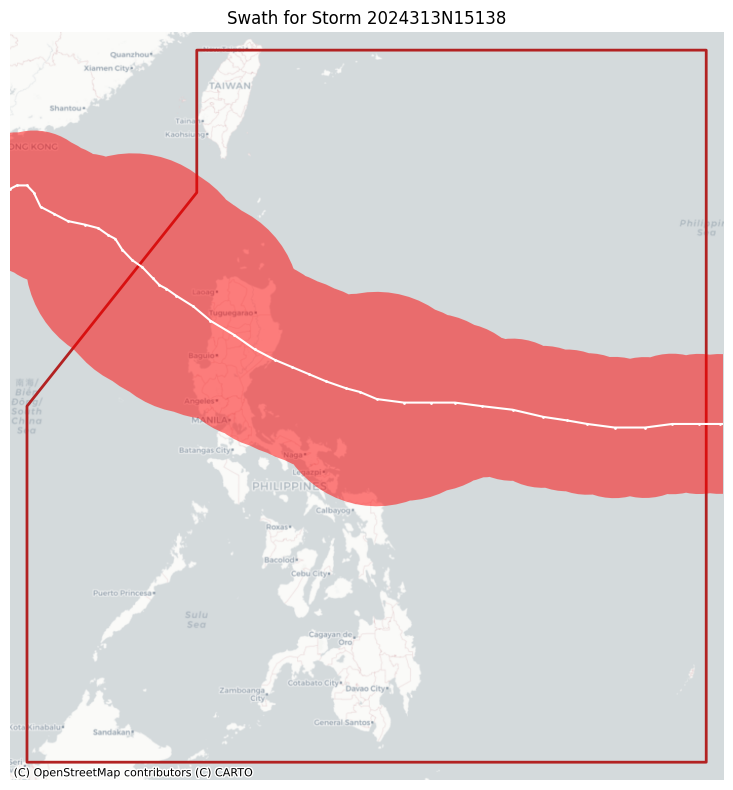

In [11]:
_, ax = plt.subplots(figsize=(8, 8))

gdf_par.plot(ax=ax, color="none", edgecolor="firebrick", linewidth=2)

x_min, y_min, x_max, y_max = gdf_par.total_bounds
padding = 0.5
ax.set_xlim(x_min - padding, x_max + padding)
ax.set_ylim(y_min - padding, y_max + padding)

cx.add_basemap(ax, crs=gdf_boundaries.crs, source=cx.providers.CartoDB.Positron)

storm_id = gdf_storms_par["SID"].unique()[-3]
swath = gdf_swaths[gdf_swaths["SID"] == storm_id]
swath.plot(ax=ax, color="red", alpha=0.5)

track = gdf_storms_par[gdf_storms_par["SID"] == storm_id]
ax.plot(track.geometry.x, track.geometry.y, marker="o", linestyle="-", markersize=1, color="white")

plt.title(f"Swath for Storm {storm_id}")
plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
del gdf_storms, swaths

## 4 Filter storms that intersect the transport network

In [13]:
graph_transport = ox.load_graphml(TRANSPORT_NETWORK_FILE)
gdf_transport = ox.graph_to_gdfs(graph_transport, nodes=False)
gdf_transport.head()

osmid    highway oneway       reversed  \
u         v           key                                                
300744370 2530205870  0     245920268   tertiary  False  [False, True]   
          12758303623 0     289934621   tertiary  False  [False, True]   
          2934697711  0    1185807595   tertiary  False  [False, True]   
300744933 2530203165  0     291446757  secondary  False           True   
          8292228841  0     291446757  secondary  False  [False, True]   

                                length  mode  \
u         v           key                      
300744370 2530205870  0     903.402532  road   
          12758303623 0    1174.859606  road   
          2934697711  0     217.508112  road   
300744933 2530203165  0     142.887806  road   
          8292228841  0     365.061260  road   

                                                                    geometry  \
u         v           key                                                      
300744370 2530205870  0    LINESTRING (124.04017 11.76647, 124.03957 11.7...   
          12758303623 0    LINESTRING (124.0277 11.75516, 124.02796 11.75...   
          2934697711  0    LINESTRING (124.03235 11.76396, 124.03309 11.7...   
300744933 2530203165  0    LINESTRING (124.06395 11.76468, 124.06457 11.7...   
          8292228841  0    LINESTRING (124.0623 11.76751, 124.06249 11.76...   

                          lanes name  ref bridge service maxspeed access  \
u         v           key                                                  
300744370 2530205870  0     NaN  NaN  NaN    NaN     NaN      NaN    NaN   
          12758303623 0       2  NaN  NaN    NaN     NaN      NaN    NaN   
          2934697711  0       2  NaN  NaN    NaN     NaN      NaN    NaN   
300744933 2530203165  0     NaN  NaN  NaN    NaN     NaN      NaN    NaN   
          8292228841  0     NaN  NaN  NaN    NaN     NaN      NaN    NaN   

                          width junction tunnel  
u         v           key                        
300744370 2530205870  0     NaN      NaN    NaN  
          12758303623 0     NaN      NaN    NaN  
          2934697711  0     NaN      NaN    NaN  
300744933 2530203165  0     NaN      NaN    NaN  
          8292228841  0     NaN      NaN    NaN

In [14]:
xmin, ymin, xmax, ymax = gdf_boundaries.total_bounds
crop_box = box(xmin, ymin, xmax, ymax)
gdf_swaths = gpd.clip(gdf_swaths, crop_box)

intersecting_swath_ids = gpd.sjoin(gdf_swaths, gdf_transport, how="inner", predicate="intersects")[
    "SID"
].unique()
gdf_swaths = gdf_swaths[gdf_swaths["SID"].isin(intersecting_swath_ids)]
gdf_storms_par = gdf_storms_par[gdf_storms_par["SID"].isin(intersecting_swath_ids)]

print(f"Filtered to {len(intersecting_swath_ids)} storms that intersect the Bicol transport network.")

Filtered to 671 storms that intersect the Bicol transport network.


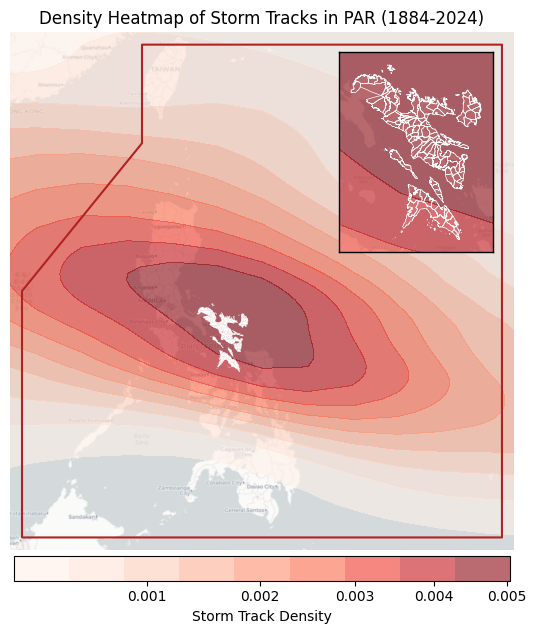

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

gdf_par.plot(ax=ax, color="none", edgecolor="firebrick", linewidth=1.5, zorder=3)
gdf_boundaries.plot(ax=ax, color="white", edgecolor="white", linewidth=0.1, zorder=4)
sns.kdeplot(
    x=gdf_storms_par.geometry.x,
    y=gdf_storms_par.geometry.y,
    ax=ax,
    cmap="Reds",
    fill=True,
    alpha=0.6,
    zorder=2,
    cbar=True,
    cbar_kws={
        "label": "Storm Track Density",
        "orientation": "horizontal",
        "pad": 0.01,
        "shrink": 0.8,
        "ticks": plt.matplotlib.ticker.MaxNLocator(5),
    },
)

x_min_par, y_min_par, x_max_par, y_max_par = gdf_par.total_bounds
padding = 0.5
ax.set_xlim(x_min_par - padding, x_max_par + padding)
ax.set_ylim(y_min_par - padding, y_max_par + padding)

cx.add_basemap(
    ax,
    crs=gdf_boundaries.crs,
    source=cx.providers.CartoDB.Positron,
    attribution="",
    zorder=1,
)

min_year, max_year = int(gdf_storms_par["SEASON"].min()), int(gdf_storms_par["SEASON"].max())
ax.set_title(f"Density Heatmap of Storm Tracks in PAR ({min_year}-{max_year})")
ax.set_axis_off()

ax_inset = fig.add_axes([0.58, 0.605, 0.25, 0.25])

gdf_boundaries.plot(ax=ax_inset, color="none", edgecolor="white", linewidth=0.5, zorder=3)
sns.kdeplot(
    x=gdf_storms_par.geometry.x,
    y=gdf_storms_par.geometry.y,
    ax=ax_inset,
    cmap="Reds",
    fill=True,
    alpha=0.6,
    zorder=2,
)

x_min_bicol, y_min_bicol, x_max_bicol, y_max_bicol = gdf_boundaries.total_bounds
inset_padding = 0.2
ax_inset.set_xlim(x_min_bicol - inset_padding, x_max_bicol + inset_padding)
ax_inset.set_ylim(y_min_bicol - inset_padding, y_max_bicol + inset_padding)

cx.add_basemap(
    ax_inset,
    crs=gdf_boundaries.crs,
    source=cx.providers.CartoDB.Positron,
    attribution="",
    zorder=1,
)
ax_inset.set_xticks([])
ax_inset.set_yticks([])
ax_inset.set_xlabel("")
ax_inset.set_ylabel("")
for spine in ax_inset.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1)

filepath = os.path.join(BASE_PATH, "storm_density_heatmap.png")
plt.savefig(filepath, dpi=300, bbox_inches="tight")
plt.show()

## 6 Save data into file

In [ ]:
img_dir = os.path.join(BASE_PATH, "storm_swath_images")
os.makedirs(img_dir, exist_ok=True)

for sid in gdf_swaths["SID"]:
    swath = gdf_swaths[gdf_swaths["SID"] == sid]
    track = gdf_storms_par[gdf_storms_par["SID"] == sid]

    _, ax = plt.subplots(figsize=(8, 8))

    gdf_boundaries.plot(ax=ax, color="none", edgecolor="gray", linewidth=1)
    swath.plot(ax=ax, color="red", alpha=0.5, zorder=1)
    ax.plot(
        track.geometry.x, track.geometry.y, marker="o", linestyle="-", markersize=1, color="white", zorder=2
    )

    x_min, y_min, x_max, y_max = gdf_boundaries.total_bounds
    padding = 0
    ax.set_xlim(x_min - padding, x_max + padding)
    ax.set_ylim(y_min - padding, y_max + padding)

    cx.add_basemap(ax, crs=gdf_swaths.crs, source=cx.providers.CartoDB.Positron, attribution="")

    plt.title(f"Storm Swath: {sid}")
    plt.axis("off")
    plt.tight_layout()

    out_path = os.path.join(img_dir, f"{sid}.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()

In [ ]:
dirpath = os.path.join(BASE_PATH, "storm_swath_geometries")
os.makedirs(dirpath, exist_ok=True)

for index, row in gdf_swaths.iterrows():
    sid = row["SID"]
    gdf_single_swath = gpd.GeoDataFrame([{"SID": sid, "geometry": row["geometry"]}], crs=gdf_swaths.crs)
    filepath = os.path.join(dirpath, f"{sid}.gpkg")
    gdf_single_swath.to_file(filepath, driver="GPKG")